# Введение

1. Название проекта: Телеком — Поиск клиента с неоптимальными тарифами
2. Исходные данные: датасеты telecom_dataset.csv (логи) и telecom_clients.csv (клиенты).
3. Цели и задачи: найти клиентов, которые: а) переплачивают на текущих тарифах; б) сэкономят, если перейдут на более дорогой тариф; решить проблему неоптимальных тарифов и потенциального оттока пользователей.
4. Этапы исследования: открытие файла с данными и изучение общей информации, предобработка данных, исследовательский анализ данных (изучение ситуации при использовании различных тарифов, изучение выручки и переплат), проверка статистических гипотез, выводы.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats

## Выгрузка данных

In [2]:
calls_log = pd.read_csv('https://code.s3.yandex.net/datasets/telecom_dataset.csv')
clients = pd.read_csv('https://code.s3.yandex.net/datasets/telecom_clients.csv')

### Датафрейм с логами звонков

In [3]:
calls_log.info()
calls_log.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


Что нужно изменить:
- столбец date привести к типу datetime, а после оставить только дату
- столбец internal привести к типу boolean
- столбец operator_id привести к типу integer

Много пропусков в столбце operator_id - произошло это по большей части из-за слишком коротких звонков: клиенты сбрасывали, не дождавшись распределения по операторам колл-центра, в итоге на звонок не был назначен ни один из операторов. Несущественная информация, в изменении не нуждается.

Немного пропусков в столбце internal - довольно важная информация, требуется либо вставить какое-то значение (например, самое популярное), либо вовсе удалить эти строчки.

### Датафрейм с информацией о клиентах

In [4]:
clients.info()
clients.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


Всё хорошо, датафрейм в изменениях не нуждается.

## Предобработка данных

### Приведение столбцов к корректным типам данных

In [5]:
calls_log['date'] = pd.to_datetime(calls_log['date']).dt.date
calls_log = calls_log.astype({'internal': 'boolean', 'operator_id': 'Int64'})

In [6]:
display(calls_log.dtypes)
calls_log.head()

user_id                  int64
date                    object
direction               object
internal               boolean
operator_id              Int64
is_missed_call            bool
calls_count              int64
call_duration            int64
total_call_duration      int64
dtype: object

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,<NA>,True,2,0,4
1,166377,2019-08-05,out,True,880022,True,3,0,5
2,166377,2019-08-05,out,True,880020,True,1,0,1
3,166377,2019-08-05,out,True,880020,False,1,10,18
4,166377,2019-08-05,out,False,880022,True,3,0,25


### Обработка пропущенных значений

In [7]:
calls_log['internal'].value_counts()

internal
False    47621
True      6164
Name: count, dtype: Int64

В подавляющем большинстве случаев звонки внешние, что логично. Так как пропусков в столбце internal относительно мало, их можно заменить значением False - маркером внешнего звонка.

In [8]:
calls_log['internal'].fillna(False, inplace=True)
calls_log['internal'].isna().sum() # проверяем, что пропусков больше нет

0

### Обработка дубликатов

In [9]:
calls_log.duplicated().sum()
# количество полных дубликатов 

4900

In [10]:
calls_log[calls_log.duplicated(keep=False)].head(10)
# проверяем, что это действительно дубликаты, которые необходимо удалить (на всякий случай)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
6,166377,2019-08-05,out,False,880020,True,8,0,50
8,166377,2019-08-05,out,False,880020,True,8,0,50
27,166377,2019-08-12,in,False,<NA>,True,2,0,34
28,166377,2019-08-12,in,False,<NA>,True,2,0,34
38,166377,2019-08-14,in,False,<NA>,True,1,0,3
43,166377,2019-08-14,out,False,880026,False,10,1567,1654
44,166377,2019-08-14,out,False,880026,False,10,1567,1654
45,166377,2019-08-14,in,False,<NA>,True,1,0,3
46,166377,2019-08-15,out,False,880026,False,11,1413,1473
51,166377,2019-08-15,out,False,880026,False,11,1413,1473


In [11]:
# удалим эти дубликаты
calls_log = calls_log.drop_duplicates().reset_index(drop=True)
calls_log.shape[0]

49002

In [12]:
clients.duplicated(subset=['user_id']).sum()
# количество дубликатов в разрезе идентификатора клиента

0

Дубликатов нет, изменять нечего.

### Промежуточные выводы

Были приведены к корректному типу данных некоторые столбцы датафрейма с логами, обработаны пропуски и дубликаты.

## Исследовательский анализ данных

### Подсчёт стоимости одного месяца для каждого клиента

In [13]:
calls_log['month'] = pd.to_datetime(calls_log['date']).dt.month
calls_log.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,month
0,166377,2019-08-04,in,False,<NA>,True,2,0,4,8
1,166377,2019-08-05,out,True,880022,True,3,0,5,8
2,166377,2019-08-05,out,True,880020,True,1,0,1,8
3,166377,2019-08-05,out,True,880020,False,1,10,18,8
4,166377,2019-08-05,out,False,880022,True,3,0,25,8


In [14]:
# создадим сгруппированный по клиентам и месяцам датафрейм
grouped_df = calls_log.groupby(['user_id', 'month'])['calls_count'].sum().reset_index().drop('calls_count', axis=1)
grouped_df.head()

,user_id,month
0,166377,8
1,166377,9
2,166377,10
3,166377,11
4,166391,8


In [15]:
# посчитаем, сколько секунд в месяц операторы каждого колл-центра звонят друг другу
internal_out_calls = (calls_log[np.logical_and(calls_log['direction'] == 'out', calls_log['internal'] == True)]
              .groupby(['user_id', 'month'])['total_call_duration'].sum()
             ).reset_index()

internal_out_calls = internal_out_calls.rename(columns={'total_call_duration': 'internal_out_calls_duration'})

grouped_df = grouped_df.merge(internal_out_calls, on=['user_id', 'month'], how='left') # объединяем датафреймы
grouped_df.head()

,user_id,month,internal_out_calls_duration
0,166377,8,96.0
1,166377,9,9.0
2,166377,10,5.0
3,166377,11,127.0
4,166391,8,7.0


In [16]:
# посчитаем, сколько секунд в месяц операторы каждого колл-центра звонят своим клиентам
external_out_calls = (calls_log[np.logical_and(calls_log['direction'] == 'out', calls_log['internal'] == False)]
                      .groupby(['user_id', 'month'])['total_call_duration'].sum()
                     ).reset_index()

external_out_calls = external_out_calls.rename(columns={'total_call_duration': 'external_out_calls_duration'})

grouped_df = grouped_df.merge(external_out_calls, on=['user_id', 'month'], how='left') # объединяем датафреймы
grouped_df.head()

,user_id,month,internal_out_calls_duration,external_out_calls_duration
0,166377,8,96.0,78029.0
1,166377,9,9.0,105835.0
2,166377,10,5.0,99207.0
3,166377,11,127.0,95384.0
4,166391,8,7.0,NaN


In [17]:
# добавим в сгруппированный датафрейм информацию о тарифном плане клиента
grouped_df = grouped_df.merge(clients, on='user_id').drop('date_start', axis=1)
grouped_df.head()

,user_id,month,internal_out_calls_duration,external_out_calls_duration,tariff_plan
0,166377,8,96.0,78029.0,B
1,166377,9,9.0,105835.0,B
2,166377,10,5.0,99207.0,B
3,166377,11,127.0,95384.0,B
4,166391,8,7.0,NaN,C


In [18]:
# добавим в сгруппированный датафрейм информацию о количестве операторов
amount_of_operators = calls_log.groupby(['user_id', 'month'])['operator_id'].nunique()

grouped_df = grouped_df.merge(amount_of_operators, on=['user_id', 'month'])
grouped_df = grouped_df.rename(columns={'operator_id': 'amount_of_operators'})
grouped_df.head()

,user_id,month,internal_out_calls_duration,external_out_calls_duration,tariff_plan,amount_of_operators
0,166377,8,96.0,78029.0,B,5
1,166377,9,9.0,105835.0,B,4
2,166377,10,5.0,99207.0,B,5
3,166377,11,127.0,95384.0,B,4
4,166391,8,7.0,NaN,C,2


Заменим все значения NaN на 0: если информации об этих звонках нет, значит, вероятнее всего, самих этих звонков не было => время равно 0.

In [19]:
grouped_df = grouped_df.fillna(0)
grouped_df.head()

,user_id,month,internal_out_calls_duration,external_out_calls_duration,tariff_plan,amount_of_operators
0,166377,8,96.0,78029.0,B,5
1,166377,9,9.0,105835.0,B,4
2,166377,10,5.0,99207.0,B,5
3,166377,11,127.0,95384.0,B,4
4,166391,8,7.0,0.0,C,2


In [20]:
def calculation(row):
    """
    Функция подсчёта стоимости одного месяца абонентской связи. Она получается по следующей формуле:
    Количество превысивших лимит минут для внутренних исходящих звонков (remaining_minutes) * 
    Цена сверх лимита (exceeding_limit) + 
    Стоимость исходящих внешних звонков (external_out_price) +
    Стоимость тарифа (fixed_price) + 
    Количество операторов (row['amount_of_operators']) * 
    Стоимость одного оператора (price_per_operator).
    Входящие звонки в расчёт не берём, так как их стоимость равна 0.
    """
    if row['tariff_plan'] == 'A':
        remaining_minutes = 2000 - row['internal_out_calls_duration'] / 60
        exceeding_limit = 0.1
        external_out_price = row['external_out_calls_duration'] / 60 * 0.3
        fixed_price = 4000
        price_per_operator = 50
        
    elif row['tariff_plan'] == 'B':
        remaining_minutes = 500 - row['internal_out_calls_duration'] / 60
        exceeding_limit = 0.15
        external_out_price = row['external_out_calls_duration'] / 60 * 0.5
        fixed_price = 2000
        price_per_operator = 150
        
    else:
        remaining_minutes = 0 - row['internal_out_calls_duration'] / 60
        exceeding_limit = 0.3
        external_out_price = row['external_out_calls_duration'] / 60 * 0.7
        fixed_price = 1000
        price_per_operator = 300
        
        
    if remaining_minutes < 0:
        internal_out_price = abs(remaining_minutes) * exceeding_limit
    else:
        internal_out_price = 0
        
    
    return internal_out_price + external_out_price + fixed_price + row['amount_of_operators'] * price_per_operator

In [21]:
grouped_df['current_price'] = round(grouped_df.apply(calculation, axis=1), 2)
grouped_df.head()

,user_id,month,internal_out_calls_duration,external_out_calls_duration,tariff_plan,amount_of_operators,current_price
0,166377,8,96.0,78029.0,B,5,3400.24
1,166377,9,9.0,105835.0,B,4,3481.96
2,166377,10,5.0,99207.0,B,5,3576.72
3,166377,11,127.0,95384.0,B,4,3394.87
4,166391,8,7.0,0.0,C,2,1600.04


### Подсчёт стоимости одного месяца при использовании различных тарифов

In [22]:
def calculationA(row):
    """
    Функция подсчёта стоимости одного месяца абонентской связи при использовании тарифа A.
    Работает аналогично функции calculation
    """
    remaining_minutes = 2000 - row['internal_out_calls_duration'] / 60
    exceeding_limit = 0.1
    external_out_price = row['external_out_calls_duration'] / 60 * 0.3
    fixed_price = 4000
    price_per_operator = 50
        
        
    if remaining_minutes < 0:
        internal_out_price = abs(remaining_minutes) * exceeding_limit
    else:
        internal_out_price = 0
        
    
    return internal_out_price + external_out_price + fixed_price + row['amount_of_operators'] * price_per_operator

In [23]:
def calculationB(row):
    """
    Функция подсчёта стоимости одного месяца абонентской связи при использовании тарифа B.
    Работает аналогично функции calculation
    """
    remaining_minutes = 500 - row['internal_out_calls_duration'] / 60
    exceeding_limit = 0.15
    external_out_price = row['external_out_calls_duration'] / 60 * 0.5
    fixed_price = 2000
    price_per_operator = 150
        
        
    if remaining_minutes < 0:
        internal_out_price = abs(remaining_minutes) * exceeding_limit
    else:
        internal_out_price = 0
        
    
    return internal_out_price + external_out_price + fixed_price + row['amount_of_operators'] * price_per_operator

In [24]:
def calculationC(row):
    """
    Функция подсчёта стоимости одного месяца абонентской связи при использовании тарифа C.
    Работает аналогично функции calculation
    """
    remaining_minutes = 0 - row['internal_out_calls_duration'] / 60
    exceeding_limit = 0.3
    external_out_price = row['external_out_calls_duration'] / 60 * 0.7
    fixed_price = 1000
    price_per_operator = 300
        
        
    if remaining_minutes < 0:
        internal_out_price = abs(remaining_minutes) * exceeding_limit
    else:
        internal_out_price = 0
        
    
    return internal_out_price + external_out_price + fixed_price + row['amount_of_operators'] * price_per_operator

In [25]:
grouped_df['price_A'] = round(grouped_df.apply(calculationA, axis=1), 2)
grouped_df['price_B'] = round(grouped_df.apply(calculationB, axis=1), 2)
grouped_df['price_C'] = round(grouped_df.apply(calculationC, axis=1), 2)

grouped_df.head(10)

,user_id,month,internal_out_calls_duration,external_out_calls_duration,tariff_plan,amount_of_operators,current_price,price_A,price_B,price_C
0,166377,8,96.0,78029.0,B,5,3400.24,4640.15,3400.24,3410.82
1,166377,9,9.0,105835.0,B,4,3481.96,4729.18,3481.96,3434.79
2,166377,10,5.0,99207.0,B,5,3576.72,4746.04,3576.72,3657.44
3,166377,11,127.0,95384.0,B,4,3394.87,4676.92,3394.87,3313.45
4,166391,8,7.0,0.0,C,2,1600.04,4100.00,2300.00,1600.04
5,166391,9,0.0,0.0,C,1,1300.00,4050.00,2150.00,1300.00
6,166391,10,0.0,0.0,C,0,1000.00,4000.00,2000.00,1000.00
7,166391,11,0.0,0.0,C,1,1300.00,4050.00,2150.00,1300.00
8,166392,8,0.0,0.0,C,2,1600.00,4100.00,2300.00,1600.00
9,166392,9,0.0,0.0,C,2,1600.00,4100.00,2300.00,1600.00


Нас больше не интересует информация, использованная для подсчёта стоимости тарифов, поэтому её можно удалить.

In [26]:
grouped_df.drop(['internal_out_calls_duration', 'external_out_calls_duration', 'amount_of_operators'], axis=1, inplace=True)
grouped_df.head()

,user_id,month,tariff_plan,current_price,price_A,price_B,price_C
0,166377,8,B,3400.24,4640.15,3400.24,3410.82
1,166377,9,B,3481.96,4729.18,3481.96,3434.79
2,166377,10,B,3576.72,4746.04,3576.72,3657.44
3,166377,11,B,3394.87,4676.92,3394.87,3313.45
4,166391,8,C,1600.04,4100.00,2300.00,1600.04


### Переплата клиентов 

In [27]:
# стоимость по самому выгодному тарифу
grouped_df['best_tariff_price'] = grouped_df.apply(lambda x: min(x['price_A'], x['price_B'], x['price_C']), axis=1)
grouped_df.head()

,user_id,month,tariff_plan,current_price,price_A,price_B,price_C,best_tariff_price
0,166377,8,B,3400.24,4640.15,3400.24,3410.82,3400.24
1,166377,9,B,3481.96,4729.18,3481.96,3434.79,3434.79
2,166377,10,B,3576.72,4746.04,3576.72,3657.44,3576.72
3,166377,11,B,3394.87,4676.92,3394.87,3313.45,3313.45
4,166391,8,C,1600.04,4100.00,2300.00,1600.04,1600.04


In [28]:
# столбец с переплатой в сравнении с лучшим тарифом
grouped_df['overpayment'] = grouped_df['current_price'] - grouped_df['best_tariff_price']

grouped_df.head()

,user_id,month,tariff_plan,current_price,price_A,price_B,price_C,best_tariff_price,overpayment
0,166377,8,B,3400.24,4640.15,3400.24,3410.82,3400.24,0.00
1,166377,9,B,3481.96,4729.18,3481.96,3434.79,3434.79,47.17
2,166377,10,B,3576.72,4746.04,3576.72,3657.44,3576.72,0.00
3,166377,11,B,3394.87,4676.92,3394.87,3313.45,3313.45,81.42
4,166391,8,C,1600.04,4100.00,2300.00,1600.04,1600.04,0.00


### Активность клиентов

На данном этапе, когда мы получили переплату для каждого месяца, можно разбить клиентов на две группы: актуальных (тех, кто совершал звонки в последний 11 месяц) и неактуальных (кто, соответственно, не совершал). С первыми мы будем работать большую часть времени, а вторых используем для нахождения значения переплаты, достигнув которое пользователи уходят от нас.

In [29]:
# находим клиентов, последний месяц активности которых не равен 11
inactive_clients = grouped_df.groupby('user_id')['month'].max().reset_index()
inactive_clients = inactive_clients[inactive_clients['month'] != 11].reset_index(drop=True)
inactive_clients.head()

,user_id,month
0,166399,10
1,166481,10
2,166507,8
3,166554,8
4,166584,8


Мы рассматриваем только последний месяц "жизни" неактивных клиентов, так как он наиболее точно отражает "настроение" пользователей.

In [30]:
# добавляем в этот датафрейм информацию о переплате
grouped_df_inactive = inactive_clients.merge(grouped_df, on=['user_id', 'month'], how='left')
grouped_df_inactive = grouped_df_inactive[['user_id', 'overpayment']]
grouped_df_inactive.head()

,user_id,overpayment
0,166399,0.0
1,166481,3000.0
2,166507,0.0
3,166554,1000.0
4,166584,0.0


Для простоты примем, что все эти клиенты ушли из-за высоких цен на тарифы.

В таком случае, если переплата равна 0, то мы ничего не можем сделать для их удержания (только изменить стоимость тарифов, но это вне нашей компетенции), поэтому для анализа следует оставить только тех клиентов, чья переплата больше 0 - за них в теории можно "побороться".

In [31]:
grouped_df_inactive = grouped_df_inactive[grouped_df_inactive['overpayment'] > 0]
grouped_df_inactive.head()

,user_id,overpayment
1,166481,3000.00
3,166554,1000.00
11,166941,1000.00
14,166958,850.00
16,167009,527.32


In [32]:
print(f'{round(grouped_df_inactive["overpayment"].median())} рублей - медианное значение переплаты, достигнув которое клиенты с повышенным шансом уходят.')

850 рублей - медианное значение переплаты, достигнув которое клиенты с повышенным шансом уходят.


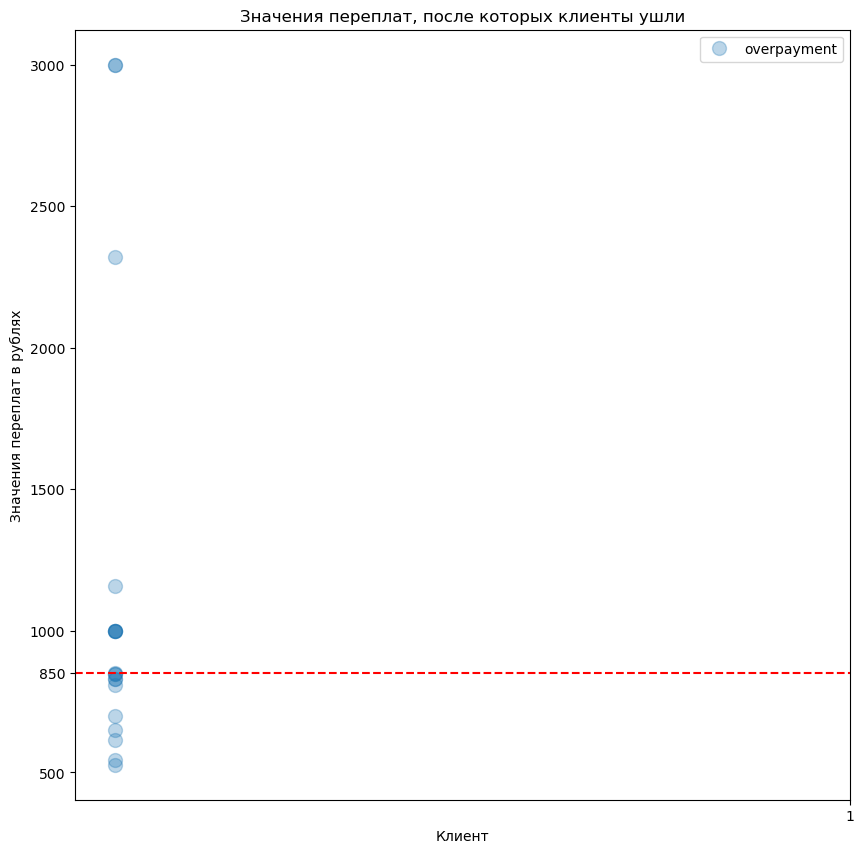

In [33]:
grouped_df_inactive['user_id'] = 0

grouped_df_inactive.plot(x='user_id', y='overpayment', style='.', alpha=0.3, figsize=(10, 10), ms=20)
plt.axhline(y=850, color='red', linestyle='--')

plt.title('Значения переплат, после которых клиенты ушли')
plt.xticks([1])
plt.yticks([500, 850, 1000, 1500, 2000, 2500, 3000])
plt.xlabel('Клиент')
plt.ylabel('Значения переплат в рублях');

В дальнейшем мы будем использовать значения 850 рублей и выше как нежелательные для переплаты клиентами.

На этом работа с неактивными пользователями завершена. Уберём этих пользователей из датафрейма grouped_df, с которым в дальнейшем будем заниматься.

In [34]:
grouped_df = grouped_df[grouped_df['user_id'].isin(inactive_clients['user_id']) == False].reset_index(drop=True)
grouped_df.head()

,user_id,month,tariff_plan,current_price,price_A,price_B,price_C,best_tariff_price,overpayment
0,166377,8,B,3400.24,4640.15,3400.24,3410.82,3400.24,0.00
1,166377,9,B,3481.96,4729.18,3481.96,3434.79,3434.79,47.17
2,166377,10,B,3576.72,4746.04,3576.72,3657.44,3576.72,0.00
3,166377,11,B,3394.87,4676.92,3394.87,3313.45,3313.45,81.42
4,166391,8,C,1600.04,4100.00,2300.00,1600.04,1600.04,0.00


### Исследование переплаты клиентов

Для нахождения пользователей, находящихся в "критической зоне" (тех, кто много переплачивает и кто может уйти к конкурентам), следует оставить информацию только об 11 месяце: данные до этого момента нас не сильно интересуют, так как вряд ли подскажут нынешнее "настроение" клиентов.

In [35]:
grouped_df_last_month = grouped_df[grouped_df['month'] == 11].reset_index(drop=True).drop('month', axis=1)
grouped_df_last_month.head()

,user_id,tariff_plan,current_price,price_A,price_B,price_C,best_tariff_price,overpayment
0,166377,B,3394.87,4676.92,3394.87,3313.45,3313.45,81.42
1,166391,C,1300.00,4050.00,2150.00,1300.00,1300.00,0.00
2,166392,C,1600.00,4100.00,2300.00,1600.00,1600.00,0.00
3,166405,B,6590.22,6434.13,6590.22,8146.88,6434.13,156.09
4,166406,B,2694.12,4336.47,2694.12,2151.76,2151.76,542.36


Добавим столбцы, аналогичные best_tariff_price и overpayment, но для среднего по выгоде тарифа - на него можно будет перевести некоторых клиентов, чей шанс уйти не слишком велик, чтобы избежать дополнительных потерь выручки.

In [36]:
# стоимость по среднему (по выгоде) тарифу
grouped_df_last_month['mid_tariff_price'] = (grouped_df_last_month
                                             .apply(lambda x: np.median([x['price_A'], x['price_B'], x['price_C']]), axis=1))

# столбец с переплатой в сравнении со средним тарифом
grouped_df_last_month['overpayment_mid'] = grouped_df_last_month['current_price'] - grouped_df_last_month['mid_tariff_price']

grouped_df_last_month.head()

,user_id,tariff_plan,current_price,price_A,price_B,price_C,best_tariff_price,overpayment,mid_tariff_price,overpayment_mid
0,166377,B,3394.87,4676.92,3394.87,3313.45,3313.45,81.42,3394.87,0.0
1,166391,C,1300.00,4050.00,2150.00,1300.00,1300.00,0.00,2150.00,-850.0
2,166392,C,1600.00,4100.00,2300.00,1600.00,1600.00,0.00,2300.00,-700.0
3,166405,B,6590.22,6434.13,6590.22,8146.88,6434.13,156.09,6590.22,0.0
4,166406,B,2694.12,4336.47,2694.12,2151.76,2151.76,542.36,2694.12,0.0


In [37]:
print(f'{round(grouped_df_last_month[grouped_df_last_month["overpayment"] != 0].shape[0] / grouped_df_last_month.shape[0] * 100, 2)}% клиентов пользуются',
     'не самым выгодным тарифом и переплачивают.')

47.51% клиентов пользуются не самым выгодным тарифом и переплачивают.


In [38]:
print(f'{round(grouped_df_last_month[grouped_df_last_month["overpayment_mid"] > 0].shape[0] / grouped_df_last_month.shape[0] * 100, 2)}% клиентов пользуются',
     'самым невыгодным тарифом и сильно переплачивают.')

10.34% клиентов пользуются самым невыгодным тарифом и сильно переплачивают.


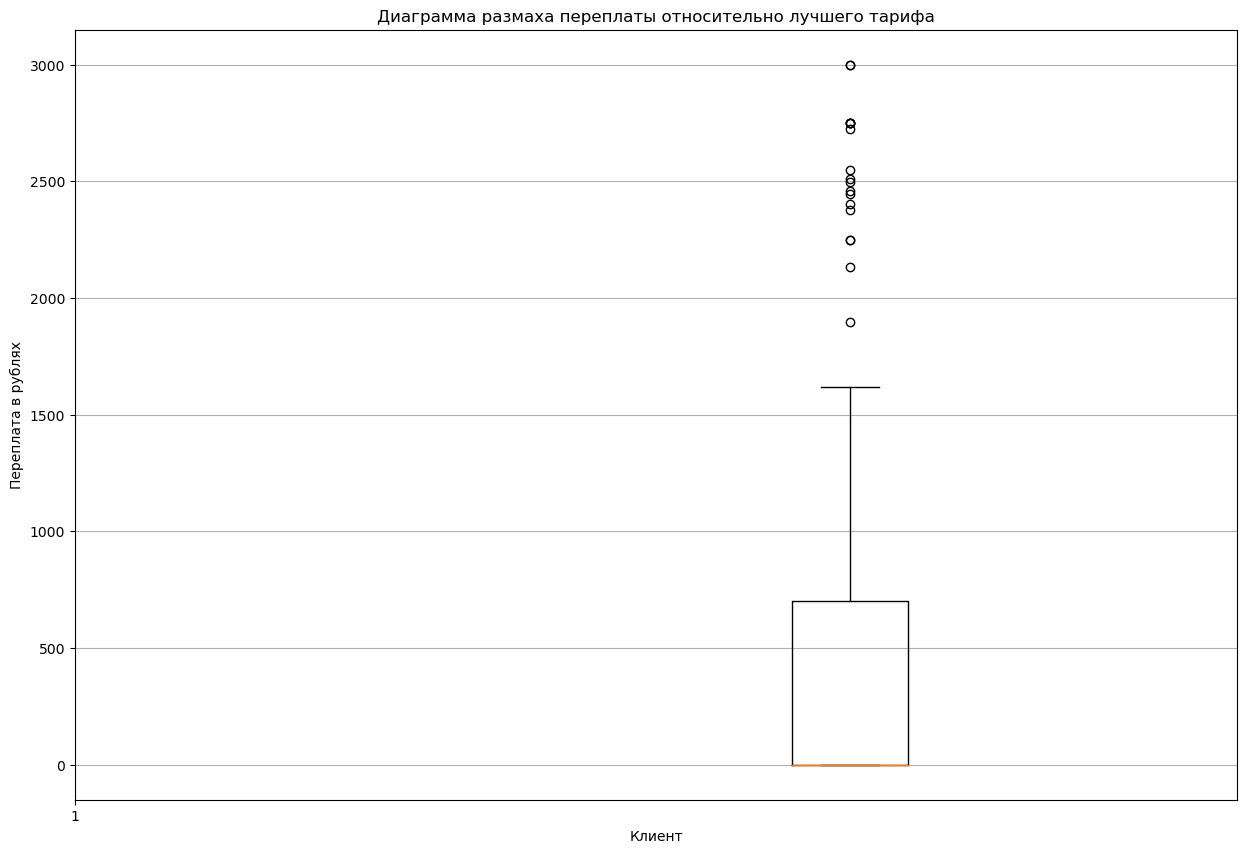

In [39]:
plt.figure(figsize=(15, 10))
plt.boxplot(grouped_df_last_month['overpayment'])
plt.title('Диаграмма размаха переплаты относительно лучшего тарифа')
plt.ylabel('Переплата в рублях')
plt.xticks([0])
plt.xlabel('Клиент')
plt.grid();

In [40]:
np.percentile(grouped_df_last_month['overpayment'], [52, 60, 80, 90]) # перцентили

array([   0.  ,  331.9 ,  849.62, 1175.36])

Большая часть клиентов (52%) используют самый выгодный тариф и не переплачивают. Около 8% пользователей переплачивают до 332 рублей, 20% - от 332 до 850, 10% - от 850 до 1175, остальные 10% - больше 1175 рублей.

### Подсчёт выручки при действующих и более выгодных тарифных планах

#### Выручка при действующих тарифных планах

In [41]:
print(f'Выручка при действующих тарифных планах: {round(grouped_df_last_month["current_price"].sum())} рублей.')

Выручка при действующих тарифных планах: 688789 рублей.


In [42]:
print(f'{round(100 - stats.percentileofscore(grouped_df_last_month["overpayment"], 850), 2)}% клиентов переплачивают больше 850 рублей.')

16.09% клиентов переплачивают больше 850 рублей.


#### Выручка при самых выгодных тарифных планах

In [43]:
print('Выручка, если заменить все тарифные планы на самые выгодные: ',
      f'{round(grouped_df_last_month["best_tariff_price"].sum())} рублей.\n\n',
      f'Это на {round((grouped_df_last_month["current_price"].sum() / grouped_df_last_month["best_tariff_price"].sum() - 1) * 100, 1)}',
      '% меньше выручки по действующим тарифам.', sep='')

Выручка, если заменить все тарифные планы на самые выгодные: 571671 рублей.

Это на 20.5% меньше выручки по действующим тарифам.


Самый действенный способ минимизировать количество уходов клиентов - это просто "пересадить" их на самый выгодный тариф. Однако в таком случае сильно страдает значение выручки: на 20% убытков компания вряд ли готова пойти.

#### Выручка при средних по выгоде тарифных планах

In [44]:
def smart_mid_tariff_price(row):
    '''
    Функция для  подсчёта стоимости месяца по среднему тарифу, если клиент платит больше, чем может, используя этот тариф 
    (мы же не будем предлагать клиентам изменить тариф на менее выгодный)
    '''
    if row['overpayment_mid'] > 0:
        return row['mid_tariff_price']
    return row['current_price']

In [45]:
grouped_df_last_month['smart_mid_tariff_price'] = grouped_df_last_month.apply(smart_mid_tariff_price, axis=1)
grouped_df_last_month['overpayment_smart_mid'] = grouped_df_last_month['smart_mid_tariff_price'] - grouped_df_last_month['best_tariff_price']
grouped_df_last_month.head()

,user_id,tariff_plan,current_price,price_A,price_B,price_C,best_tariff_price,overpayment,mid_tariff_price,overpayment_mid,smart_mid_tariff_price,overpayment_smart_mid
0,166377,B,3394.87,4676.92,3394.87,3313.45,3313.45,81.42,3394.87,0.0,3394.87,81.42
1,166391,C,1300.00,4050.00,2150.00,1300.00,1300.00,0.00,2150.00,-850.0,1300.00,0.00
2,166392,C,1600.00,4100.00,2300.00,1600.00,1600.00,0.00,2300.00,-700.0,1600.00,0.00
3,166405,B,6590.22,6434.13,6590.22,8146.88,6434.13,156.09,6590.22,0.0,6590.22,156.09
4,166406,B,2694.12,4336.47,2694.12,2151.76,2151.76,542.36,2694.12,0.0,2694.12,542.36


In [46]:
print('Выручка, если заменить невыгодные тарифные планы на средние по выгоде: ',
      f'{round(grouped_df_last_month["smart_mid_tariff_price"].sum())} рублей\n',
      f'Это на {round((grouped_df_last_month["current_price"].sum() / grouped_df_last_month["smart_mid_tariff_price"].sum() - 1) * 100, 1)}',
      '% меньше выручки по действующим тарифам.', sep='')

Выручка, если заменить невыгодные тарифные планы на средние по выгоде: 646406 рублей
Это на 6.6% меньше выручки по действующим тарифам.


In [47]:
print(f'{round(100 - stats.percentileofscore(grouped_df_last_month["overpayment_smart_mid"], 850), 2)}% клиентов переплачивают больше 850 рублей.')

7.28% клиентов переплачивают больше 850 рублей.


Хоть выручка и упала на 6.6%, количество клиентов с высокой переплатой (больше 850 рублей) уменьшилось до 7.3%.

Уже неплохо, но, скорее всего, можно лучше.

#### Выручка при "умной" тарификации

Будем изменять тарифные планы исходя из значения переплаты клиента:
- переплата выше 850 рублей:
- - если у пользователя самый невыгодный тариф, тогда мы пытаемся перейти на средний тариф; если и с ним переплата больше 850 рублей, тогда переходим на самый выгодный;
- - если у пользователя средний тариф, то переходим на самый выгодный;
- переплата ниже 850 рублей:
- - оставляем клиента на том же тарифном плане.

In [48]:
def smart_tariff_price(row):
    '''
    Функция для подсчёта стоимости месяца при самых подходящих тарифных условиях
    '''
    if row['overpayment'] > 850:
        if row['overpayment_smart_mid'] > 850:
            return row['best_tariff_price']
        return row['smart_mid_tariff_price']
            
    return row['current_price']

In [49]:
grouped_df_last_month['smart_tariff_price'] = grouped_df_last_month.apply(smart_tariff_price, axis=1)
grouped_df_last_month['overpayment_smart'] = grouped_df_last_month['smart_tariff_price'] - grouped_df_last_month['best_tariff_price']
grouped_df_last_month.head()

,user_id,tariff_plan,current_price,price_A,price_B,price_C,best_tariff_price,overpayment,mid_tariff_price,overpayment_mid,smart_mid_tariff_price,overpayment_smart_mid,smart_tariff_price,overpayment_smart
0,166377,B,3394.87,4676.92,3394.87,3313.45,3313.45,81.42,3394.87,0.0,3394.87,81.42,3394.87,81.42
1,166391,C,1300.00,4050.00,2150.00,1300.00,1300.00,0.00,2150.00,-850.0,1300.00,0.00,1300.00,0.00
2,166392,C,1600.00,4100.00,2300.00,1600.00,1600.00,0.00,2300.00,-700.0,1600.00,0.00,1600.00,0.00
3,166405,B,6590.22,6434.13,6590.22,8146.88,6434.13,156.09,6590.22,0.0,6590.22,156.09,6590.22,156.09
4,166406,B,2694.12,4336.47,2694.12,2151.76,2151.76,542.36,2694.12,0.0,2694.12,542.36,2694.12,542.36


In [50]:
print('Выручка, если использовать умную систему тарификации: ',
      f'{round(grouped_df_last_month["smart_tariff_price"].sum())} рублей\n',
      f'Это на {round((grouped_df_last_month["current_price"].sum() / grouped_df_last_month["smart_tariff_price"].sum() - 1) * 100, 1)}',
      '% меньше выручки по действующим тарифам.', sep='')

Выручка, если использовать умную систему тарификации: 633200 рублей
Это на 8.8% меньше выручки по действующим тарифам.


In [51]:
print(f'{round(100 - stats.percentileofscore(grouped_df_last_month["overpayment_smart"], 850), 2)}% клиентов переплачивают больше 850 рублей.')

2.3% клиентов переплачивают больше 850 рублей.


Система "умной" тарификации позволила бы компании сократить количество клиентов, сильно рискующих уйти, до 2.3%. Выручка сократится на 8.8%, но в долгосрочной перспективе это обязательно окупится.

In [52]:
# таблица с информацией о выручке и количестве клиентов, попавших в критическую зону (переплачивают больше 850 рублей),
# при различных тарифах
res_df = []

res_df.append({'Выручка за последний месяц в руб.': 688789, 'Потеря выручки в %': 0, 'Количество клиентов в крит. зоне в %': 16.09})
res_df.append({'Выручка за последний месяц в руб.': 571671, 'Потеря выручки в %': 20.5, 'Количество клиентов в крит. зоне в %': 0})
res_df.append({'Выручка за последний месяц в руб.': 646406, 'Потеря выручки в %': 6.6, 'Количество клиентов в крит. зоне в %': 7.28})
res_df.append({'Выручка за последний месяц в руб.': 633200, 'Потеря выручки в %': 8.8, 'Количество клиентов в крит. зоне в %': 2.3})

res_df = pd.DataFrame(res_df)
res_df.index = ['При действующих тарифах', 'При самых выгодных тарифах', 'При средних по выгоде тарифах', 'При умной тарификации']
res_df

,Выручка за последний месяц в руб.,Потеря выручки в %,Количество клиентов в крит. зоне в %
При действующих тарифах,688789,0.0,16.09
При самых выгодных тарифах,571671,20.5,0.00
При средних по выгоде тарифах,646406,6.6,7.28
При умной тарификации,633200,8.8,2.30


### Анализ выручки

#### Текущая общая выручка

In [53]:
print(f'{grouped_df["current_price"].sum()} рублей за 4 месяца компания заработала с активных клиентов.')

1829626.23 рублей за 4 месяца компания заработала с активных клиентов.


#### Выручка в разрезе тарифов

In [54]:
revenue_by_tariffs = grouped_df.groupby('tariff_plan')['current_price'].sum().sort_values(ascending=False).reset_index()
revenue_by_tariffs

,tariff_plan,current_price
0,B,707224.72
1,C,654214.53
2,A,468186.98


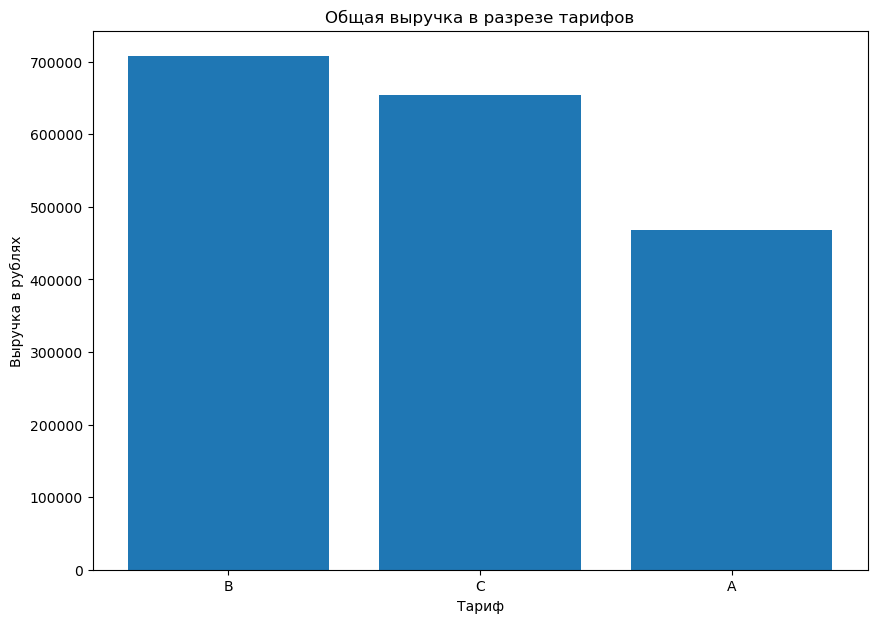

In [55]:
plt.figure(figsize=(10, 7))
plt.bar(x=revenue_by_tariffs['tariff_plan'], height=revenue_by_tariffs['current_price'])
plt.title('Общая выручка в разрезе тарифов')
plt.xlabel('Тариф')
plt.ylabel('Выручка в рублях');

Больше всего прибыли компании приносят клиенты с тарифом B, меньше всего - с тарифом A.

#### Средняя стоимость месячной абонентской платы в разрезе тарифов

In [56]:
avg_revenue_by_tariffs = grouped_df.groupby('tariff_plan')['current_price'].mean().sort_values(ascending=False).reset_index()
avg_revenue_by_tariffs

,tariff_plan,current_price
0,A,5508.082118
1,B,2668.772528
2,C,1832.533697


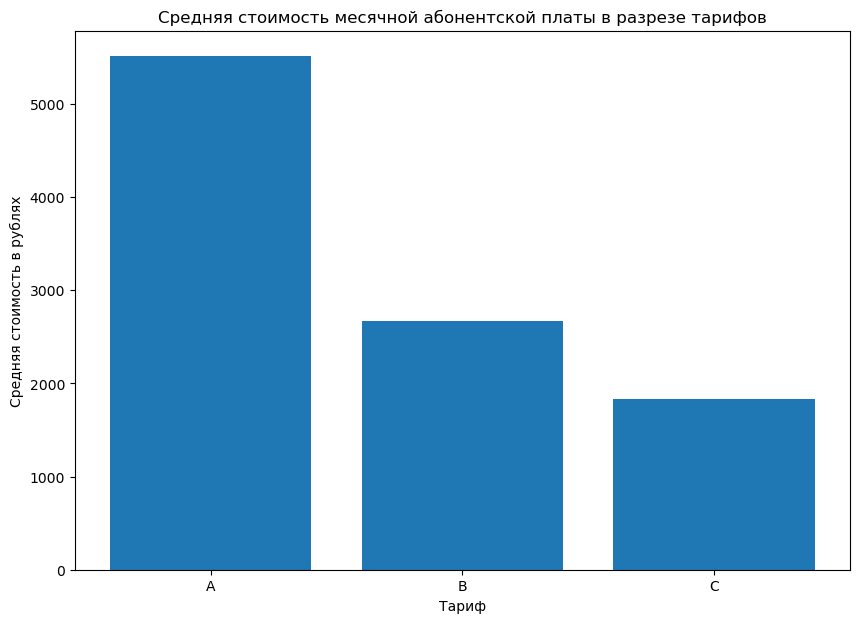

In [57]:
plt.figure(figsize=(10, 7))
plt.bar(x=avg_revenue_by_tariffs['tariff_plan'], height=avg_revenue_by_tariffs['current_price'])
plt.title('Средняя стоимость месячной абонентской платы в разрезе тарифов')
plt.xlabel('Тариф')
plt.ylabel('Средняя стоимость в рублях');

Средний клиент с тарифом A платит намного больше, чем клиент с тарифом B или С: разница выше 100%.

#### Количество клиентов в разрезе тарифов

In [58]:
amount_by_tariffs = grouped_df.groupby('tariff_plan')['user_id'].count().sort_values(ascending=False).reset_index()
amount_by_tariffs

,tariff_plan,user_id
0,C,357
1,B,265
2,A,85


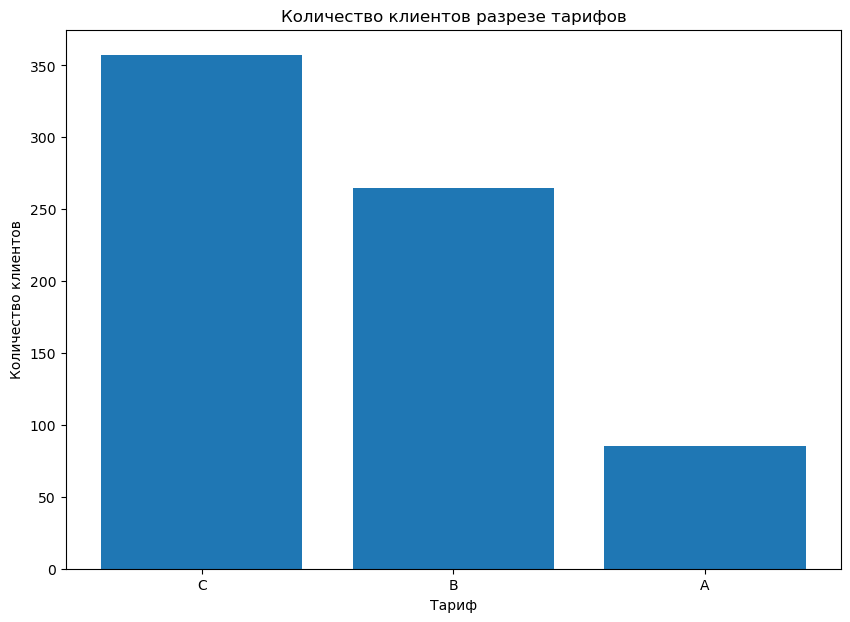

In [59]:
plt.figure(figsize=(10, 7))
plt.bar(x=amount_by_tariffs['tariff_plan'], height=amount_by_tariffs['user_id'])
plt.title('Количество клиентов разрезе тарифов')
plt.xlabel('Тариф')
plt.ylabel('Количество клиентов');

Больше всего клиентов с тарифом C, меньше всего - с тарифом A.

#### Изменение медианной выручки с клиента с течением времени

In [60]:
# для правильности подсчёта оставим в датафрейме только тех клиентов, которые с нами все 4 месяца
constant_clients = grouped_df.groupby('user_id')['month'].count().reset_index()
constant_clients = constant_clients[constant_clients['month'] == 4]['user_id']

In [61]:
# создаём лог с этими клиентами
constant_clients_log = grouped_df[grouped_df['user_id'].isin(constant_clients)]
constant_clients_log.head()

,user_id,month,tariff_plan,current_price,price_A,price_B,price_C,best_tariff_price,overpayment
0,166377,8,B,3400.24,4640.15,3400.24,3410.82,3400.24,0.00
1,166377,9,B,3481.96,4729.18,3481.96,3434.79,3434.79,47.17
2,166377,10,B,3576.72,4746.04,3576.72,3657.44,3576.72,0.00
3,166377,11,B,3394.87,4676.92,3394.87,3313.45,3313.45,81.42
4,166391,8,C,1600.04,4100.00,2300.00,1600.04,1600.04,0.00


In [62]:
# приводим датафрейм к удобному виду
monthly_income = constant_clients_log.groupby(['tariff_plan', 'month'])['current_price'].median().unstack()
monthly_income

month,8,9,10,11
tariff_plan,,,,
A,4102.065,4165.475,4226.405,4174.700
B,2293.745,2487.075,2533.440,2353.900
C,1324.820,1514.620,1460.335,1416.515


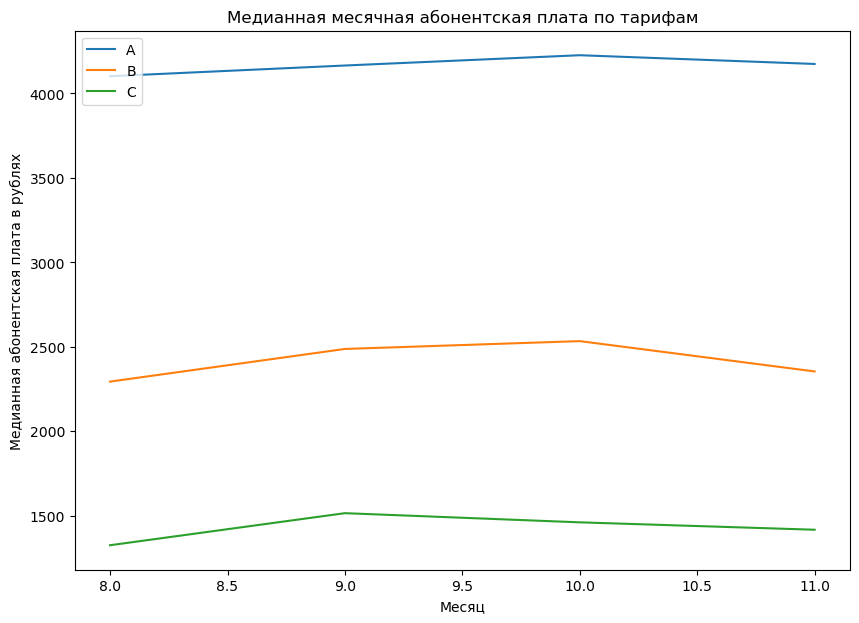

In [63]:
plt.figure(figsize=(10, 7))

for i in range(len(monthly_income.index)):
    plt.plot(monthly_income.iloc[i].index, monthly_income.iloc[i].values, label=monthly_income.index[i])
    
plt.legend(loc='upper left')
plt.title('Медианная месячная абонентская плата по тарифам')
plt.xlabel('Месяц')
plt.ylabel('Медианная абонентская плата в рублях');

Исходя из графика можно предположить, что с течением времени выручка, которую приносит один клиент, остаётся примерно на одном и том же уровне, независимо от тарифа.

### Промежуточные выводы

- 850 рублей - это значение переплаты, за которое нежелательно переступать, иначе сильно увеличивается риск ухода клиента;
- большая часть клиентов (52%) используют самый выгодный тариф и не переплачивают, около 8% пользователей переплачивают до 332 рублей, 20% - от 332 до 850, 10% - от 850 до 1175, остальные 10% - больше 1175 рублей;
- система "умной" тарификации позволяет максимально минимизировать количество ушедших клиентов, при этом не слишком сильно "просесть" в выручке: 

In [64]:
res_df

,Выручка за последний месяц в руб.,Потеря выручки в %,Количество клиентов в крит. зоне в %
При действующих тарифах,688789,0.0,16.09
При самых выгодных тарифах,571671,20.5,0.00
При средних по выгоде тарифах,646406,6.6,7.28
При умной тарификации,633200,8.8,2.30


- больше всего прибыли компании приносят клиенты с тарифом B, меньше всего - с тарифом A;
- cредний клиент с тарифом A платит намного больше, чем клиент с тарифом B или С: разница выше 100%;
- больше всего клиентов с тарифом C, меньше всего - с тарифом A;
- с течением времени выручка, которую приносит один клиент, остаётся примерно на одном и том же уровне, независимо от тарифа.

## Проверка статистических гипотез

### Цена услуг различается на тарифных планах A и B

Нулевая гипотеза: средняя стоимость месячной абонентской платы для тарифных планов A и B одинаковая. Альтернативная гипотеза: средняя стоимость месячной абонентской платы для тарифных планов A и B различается.

In [65]:
results = stats.ttest_ind(grouped_df['price_A'], grouped_df['price_B'], alternative = 'two-sided')
alpha = 0.05

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Нельзя отвергнуть нулевую гипотезу')

p-значение: 4.477856042790941e-33
Отвергаем нулевую гипотезу


Всё-таки средняя стоимость месячной абонентской платы для тарифных планов A и B различается.

### Средняя переплата, которую совершают пользователи тарифа A, не превышает 1000 рублей.

Нулевая гипотеза: средняя переплата, которую совершают пользователи тарифа A, равна 1000 рублей. Альтернативная гипотеза: средняя переплата, которую совершают пользователи тарифа A, превышает 1000 рублей.

In [66]:
sample = grouped_df[grouped_df['tariff_plan'] == 'A']['overpayment'].values
interested_value = 1000
alpha = 0.05

results = stats.ttest_1samp(sample, interested_value, alternative='greater')
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Нельзя отвергнуть нулевую гипотезу')

p-значение: 3.3944298338718224e-13
Отвергаем нулевую гипотезу


Средняя переплата, которую совершают пользователи тарифа A, превышает 1000 рублей.

# Выводы

*Все выводы, кроме найденного критического значения переплаты, равного 850 рублей, основаны на информации об актуальных клиентах*

Существует несколько глобальных стратегий для избежания оттока большого количества клиентов к конкурентам из-за высокой переплаты:
- перевести всех клиентов на самый выгодный для них тарифный план (так мы максимально снизим потенциальный отток клиентов, но при этом крайне много потеряем в выручке);
- перевести всех клиентов самого дорогого тарифного плана на средний по выгоде (ситуация улучшается, но клиентов из критической зоны всё равно многовато);
- использовать умную тарификацию: если переплата больше 850 рублей, то перевести клиента на следующий по уровню выгоды тарифный план (например, с тарифа C на тариф B); повторить, если переплата снова больше 850 рублей, а тариф не самый выгодный (количество клиентов из критической зоны становится крайне мало, но при этом довольно сильно уменьшается выручка)

Ниже представлена таблица с информацией о клиентах при использовании вышеприведённых стратегий:

In [67]:
res_df

,Выручка за последний месяц в руб.,Потеря выручки в %,Количество клиентов в крит. зоне в %
При действующих тарифах,688789,0.0,16.09
При самых выгодных тарифах,571671,20.5,0.00
При средних по выгоде тарифах,646406,6.6,7.28
При умной тарификации,633200,8.8,2.30


- большая часть клиентов (52%) используют самый выгодный тариф и не переплачивают, около 8% пользователей переплачивают до 332 рублей, 20% - от 332 до 850, 10% - от 850 до 1175, остальные 10% - больше 1175 рублей;
- больше всего прибыли компании приносят клиенты с тарифом B, меньше всего - с тарифом A;
- cредний клиент с тарифом A платит намного больше, чем клиент с тарифом B или С: разница выше 100%;
- больше всего клиентов с тарифом C, меньше всего - с тарифом A;
- с течением времени выручка, которую приносит один клиент, остаётся примерно на одном и том же уровне, независимо от тарифа.

**Рекомендации:**
- перевести клиентов на тарифные планы в соответствии с системой умной тарификации.